In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import jax
from jax import grad, jit
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
import time
import cma
from vbmc_utils_n import *

In [2]:
def expensive_log_likelihood(obs, params, weights=None):
    mu_params, s_params = params
    n_components = mu_params.shape[0]

    if s_params.ndim == 2:  
        s_params = jnp.array([jnp.diag(s) for s in s_params])
        
    # equal weights
    if weights is None:
        weights = jnp.ones(n_components)/n_components
    else:
        weights = jnp.array(weights)/jnp.sum(weights)

    terms = jnp.stack([comp_pdf(obs, mu_params[i], s_params[i]) for i in range(n_components)], axis=1)
    likelihood = jnp.sum(weights*terms, axis=1)
    log_likelihood = jnp.log(likelihood + 1e-12)
    return log_likelihood


def expensive_log_likelihood(obs, params, weights=None):
    mu_params, s_params = params  # keep same signature

    obs = jnp.atleast_2d(obs)
    x = obs[:, 0]
    y = obs[:, 1]

    # Banana-shaped PDF (unnormalized, like Rosenbrock distribution)
    a = 0.0
    b = 13.0
    pdf_vals = jnp.exp(-((a - x)**2 + b*(y - x**2)**2))  # exponential of negative Rosenbrock

    # Avoid log(0)
    log_likelihood = jnp.log(jnp.sqrt(pdf_vals) + 1e-12)
    return log_likelihood


In [3]:

# true parameters for 2D mixture
n = 0
mu_true = jnp.array([[-3, 2],[3, 2], [0, 4]])
s_true = jnp.array([[[2.0, -1.6],[-1.6, 2.0]],
                    [[2.2, 1.4],[1.4, 2.2]],
                    [[1.6, 0.0],[0.0, 1.6]]])

mu_true = jnp.array([[-1, 1],[1, 1]])
s_true = jnp.array([[[1.0, 0.0],[0.0, 1.0]],
                    [[1.0, 0.0],[0.0, 1.0]]])


params_true = (mu_true, s_true)

# per-dimension bounds
sigma = jnp.diagonal(s_true, axis1=1, axis2=2)

lower1 = jnp.min(mu_true[:, 0] - 2*sigma[:, 0])
upper1 = jnp.max(mu_true[:, 0] + 2*sigma[:, 0])
lower2 = jnp.min(mu_true[:, 1] - 2.5*sigma[:, 1])
upper2 = jnp.max(mu_true[:, 1] + 2.5*sigma[:, 1])

# lower1 = -4
# upper1 = 4
# lower2 = -2
# upper2 = 6


# grid of evaluation points
x1 = jnp.linspace(lower1, upper1, n)
x2 = jnp.linspace(lower2, upper2, n)

X1, X2 = jnp.meshgrid(x1, x2)
x_obs = jnp.column_stack([X1.ravel(), X2.ravel()])

# bottom = jnp.column_stack([x1, jnp.full_like(x1, lower2)])
# top = jnp.column_stack([x1, jnp.full_like(x1, upper2)])
# left = jnp.column_stack([jnp.full_like(x2, lower1), x2])
# right = jnp.column_stack([jnp.full_like(x2, upper1), x2])
# x_obs = jnp.vstack([bottom, top, left, right])
# x_obs = jnp.vstack([
#     bottom,
#     top,
#     left[1:-1],
#     right[1:-1]
# ])


y_obs = expensive_log_likelihood(x_obs, params_true)

# GP fit
grad_fn = grad(neg_gp_likelihood)
s_init = 5
l_init = jnp.array([10, 10])
init_params = jnp.concatenate([jnp.array([s_init]), l_init])

res = minimize(
    fun=lambda p: float(neg_gp_likelihood(p, x_obs, y_obs, rbf)),
    x0=init_params,
    jac=lambda p: jnp.array(grad_fn(p, x_obs, y_obs, rbf)),
    method="L-BFGS-B",
    bounds=[(1, 5000)]*len(init_params)
)

# kernel hyperparameters
s = res.x[0]
L = res.x[1:]
#L = jnp.array([5, 4])
print("Optimised params:", res.x)
print("Optimised log marginal likelihood:", -res.fun)

# dense evaluation grid
x1_eval = jnp.linspace(lower1, upper1, 40)
x2_eval = jnp.linspace(lower2, upper2, 40)
X1_eval, X2_eval = jnp.meshgrid(x1_eval, x2_eval)
x_eval = jnp.column_stack([X1_eval.ravel(), X2_eval.ravel()])


mu_eval, var_eval = gp_predict(x_obs, y_obs, x_eval, kernel=rbf, s=s, L=L)
sig_diag = jnp.sqrt(jnp.diag(var_eval))

# reshape for contour plotting
mu_eval_grid = mu_eval.reshape(X1_eval.shape)
log_likelihood_true = expensive_log_likelihood(x_eval, params_true).reshape(X1_eval.shape)



# plot GP mean vs true log likelihood
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cs = plt.contourf(X1_eval, X2_eval, mu_eval_grid, levels=30, cmap="magma")
plt.colorbar(cs)
plt.ylim(lower2,upper2)
plt.xlim(lower1,upper1)
plt.scatter(x_obs[:,0], x_obs[:,1], c='red', s=20, label='Observed')
plt.title("GP Surrogate Mean")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()

plt.subplot(1, 2, 2)
cs2 = plt.contourf(X1_eval, X2_eval, log_likelihood_true, levels=30, cmap="magma")
plt.colorbar(cs2)
plt.ylim(lower2,upper2)
plt.xlim(lower1,upper1)
plt.title("True Log Likelihood")
plt.xlabel("x1")
plt.ylabel("x2")

plt.tight_layout()
plt.show()


Optimised params: [ 5. 10. 10.]
Optimised log marginal likelihood: -0.0


ValueError: zero-size array to reduction operation max which has no identity

In [50]:
def gp_predict(xs, ys, x_eval, kernel, s, L, m0=None, x_m=None,w=None, chol_k=None):
    xs = jnp.asarray(xs)
    x_eval = jnp.asarray(x_eval)
    ys = jnp.asarray(ys)
    L = jnp.asarray(L)

    # Ensure 2D arrays
    if xs.ndim == 1:
        xs = xs[:, None]
    if x_eval.ndim == 1:
        x_eval = x_eval[:, None]
    if ys.ndim == 1:
        ys = ys[:, None]

    if L.ndim == 1:
        L = jnp.diag(L)

    # mean function at training and evaluation points
    if m0 is None:
        m0 = jnp.mean(ys)
        x_m = jnp.mean(xs, axis=0)
        w = (jnp.max(xs, axis=0) - jnp.min(xs, axis=0))/5.0

    m = m0 - 0.5*jnp.sum(((xs - x_m) ** 2) / (w ** 2), axis=1)
    M = m0 - 0.5*jnp.sum(((x_eval - x_m) ** 2) / (w ** 2), axis=1)

    K = kernel(xs, xs, s, L) + 1e-6*jnp.eye(xs.shape[0])
    K_s = kernel(xs, x_eval, s, L)
    K_ss = kernel(x_eval, x_eval, s, L)

    if chol_k is not None:
        n = chol_k.shape[0]
        K12 = K[:n, n:]
        K21 = K[n:, :n]
        K22 = K[n:, n:]

        S = K22 - K21 @ jax.scipy.linalg.cho_solve((chol_k, True), K12)
        def solve_S(b):
            return jnp.linalg.solve(S, b)

        top_left = jax.scipy.linalg.cho_solve((chol_k, True), jnp.eye(n)) + \
                jax.scipy.linalg.cho_solve((chol_k, True), K12) @ \
                solve_S(K21 @ jax.scipy.linalg.cho_solve((chol_k, True), jnp.eye(n)))

        top_right = -jax.scipy.linalg.cho_solve((chol_k, True), K12) @ solve_S(jnp.eye(K22.shape[0]))
        bottom_left = -solve_S(K21 @ jax.scipy.linalg.cho_solve((chol_k, True), jnp.eye(n)))
        bottom_right = solve_S(jnp.eye(K22.shape[0]))

        #Assemble updated "inverse"
        K_inv = jnp.vstack([jnp.hstack([top_left, top_right]),
                            jnp.hstack([bottom_left, bottom_right])])
        # Compute mean and covariance
        ym = ys - m[:, None]
        mu = M + (K_s.T @ K_inv @ ym).ravel()
        sig = K_ss - K_s.T @ K_inv @ K_s + 1e-9 * jnp.eye(K_ss.shape[0])
    else:
        chol_k = jnp.linalg.cholesky(K + 1e-10 * jnp.eye(K.shape[0]))
        K_inv = jax.scipy.linalg.cho_solve((chol_k, True), jnp.eye(K.shape[0]))

        ym = ys - m[:, None]
        mu = M + (K_s.T @ K_inv @ ym).ravel()
        
        v = jax.scipy.linalg.cho_solve((chol_k, True), K_s)
        sig = K_ss - K_s.T @ v + 1e-9 * jnp.eye(K_ss.shape[0])


    return mu.ravel(), sig, chol_k

In [51]:

def active_sample(x, y, s, L, 
                  alpha, beta, gamma,
                  params, ll,  n_points, chol_k):
    
    for _ in range(n_points):

        def acquistion_objective(m):
            m = jnp.atleast_2d(m)

            #gp predictions at some m
            mu_gp, var_gp, chol_k = gp_predict(x, y, m, kernel=rbf, s=s, L=L, chol_k=None)

            #mixture pdf values at some m
            mu_params = params[0]
            sigma_params = jnp.exp(params[1])
            logitweights = params[2]
            weights = jax.nn.softmax(logitweights)

            #term 1, GP predictive variance at m            
            t1 = var_gp

            #term 2, variational mixture value at m
            t2 = mixture_pdf(m, mu_params, sigma_params, weights)

            #term 3, GP predictive mean m  
            t3 = mu_gp

            acq = (t1**alpha)*(t2**beta)*(jnp.exp(t3*gamma))
            return -float(acq.item())
        

        d = x.shape[1]
        x0 = np.random.rand(d)*2 - 1
        sigma0 = 1.0
        opts = {'verb_disp': 0,
                'verb_log': 0,
                'maxiter': 15}

        es = cma.CMAEvolutionStrategy(x0, sigma0, opts)
        es.optimize(acquistion_objective)
        new_x_point = jnp.array(es.result.xbest).reshape(1, -1) 
        new_y_point = ll(new_x_point,params_true)
        x = jnp.vstack([x, new_x_point])
        y = jnp.hstack([y, new_y_point])

        K = rbf(x, x, s, jnp.diag(L)) + 1e-6*jnp.eye(x.shape[0])
        chol_k = jnp.linalg.cholesky(K + 1e-10*jnp.eye(K.shape[0]))

    grad_fn = grad(neg_gp_likelihood)
    s_init = s
    l_init = L*2
    init_params = jnp.concatenate([jnp.array([s_init]), l_init])

    res = minimize(
        fun=lambda p: float(neg_gp_likelihood(p, x, y, rbf)),
        x0=init_params,
        jac=lambda p: jnp.array(grad_fn(p, x, y, rbf)),
        method="L-BFGS-B",
        bounds=[(1, 30)]*len(init_params)
    )

    # kernel hyperparameters
    s = res.x[0]
    L = res.x[1:]
    a = jnp.max(L)

    return x, y, s, jnp.array([a,a]), chol_k



def vbmc(x, y, grad_elbo, s, L, alpha=1, 
          beta=1, gamma=1, lr=0.005, k=2, 
          n_points=1,rsp=3, n1=10, n2=20_000, 
          plots=True, ll=None, params_true=None, 
          weights=False, key=None):
    
    d = x.shape[1]

    #plausible bounds to sample from
    mu_real = params_true[0]
    sigma_real = jnp.diagonal(params_true[1], axis1=1, axis2=2)
    lower = jnp.array([jnp.min(mu_real[:, 0] - 3.5*sigma_real[:, 0]),
                       jnp.min(mu_real[:, 1] - 3.5*sigma_real[:, 1])])
    upper = jnp.array([jnp.max(mu_real[:, 0] + 3.5*sigma_real[:, 0]),
                       jnp.max(mu_real[:, 1] + 3.5*sigma_real[:, 1])])
    
    mu_true = jnp.array([[-1, 1],[1, 1]])
    s_true = jnp.array([[[1.0, 0.0],[0.0, 1.0]],
                        [[1.0, 0.0],[0.0, 1.0]]])
    # per-dimension bounds
    sigma = jnp.diagonal(s_true, axis1=1, axis2=2)
    lower1 = jnp.min(mu_true[:, 0] - 2*sigma[:, 0])
    upper1 = jnp.max(mu_true[:, 0] + 2*sigma[:, 0])
    lower2 = jnp.min(mu_true[:, 1] - 2.5*sigma[:, 1])
    upper2 = jnp.max(mu_true[:, 1] + 2.5*sigma[:, 1])

    # number of initial points
    n = 0
    key, subkey = jax.random.split(key)
    u1 = jax.random.uniform(subkey, shape=(int(n/2), d))
    u2 = 1.0 - u1
    u = jnp.vstack([u1, u2])
    point = lower + (upper - lower)*u
    new_x_points = jnp.array(point)
    new_y_points = ll(u,params_true)

    # threshold = jnp.max(new_y_points) - 1*d
    # threshold = jnp.max(y) - 1*d
    # mask = new_y_points >= threshold
    # new_x_points = new_x_points[mask]
    # new_y_points = new_y_points[mask]
    # print(f"trimmed {n-jnp.sum(mask)} points")


    # Add filtered points
    x = jnp.vstack([x, new_x_points])
    y = jnp.hstack([y, new_y_points])


    grad_fn = grad(neg_gp_likelihood)
    s_init = s
    l_init = L*2
    init_params = jnp.concatenate([jnp.array([s_init]), l_init])

    res = minimize(
        fun=lambda p: float(neg_gp_likelihood(p, x, y, rbf)),
        x0=init_params,
        jac=lambda p: jnp.array(grad_fn(p, x, y, rbf)),
        method="L-BFGS-B",
        bounds=[(1, 30)]*len(init_params)
    )

    # kernel hyperparameters
    s = res.x[0]
    L = res.x[1:]


    sigma_mean = jnp.mean(sigma_real, axis=0)
    inner_lower = lower + 4*sigma_mean
    inner_upper = upper - 4*sigma_mean

    key, subkey = jax.random.split(key)
    mu_params = inner_lower + jax.random.uniform(subkey, (k, d))*(inner_upper - inner_lower)
    s_params = 0.1*jnp.ones_like(mu_params)

    logitweights = jnp.zeros(k)
    params = (mu_params, jnp.log(s_params), logitweights)
    

    elbo_history = []
    elcbo_history = []
    best_elcbo = -jnp.inf
    np = 0

    K = rbf(x, x, s, jnp.diag(L)) + 1e-6*jnp.eye(x.shape[0])
    chol_k = jnp.linalg.cholesky(K + 1e-10*jnp.eye(K.shape[0]))
    for j in range(n1):
        if plots:
           plot_plots(x,y,s,L,np,params, params_true, ll)        
        print(f"Beggining Iter {j+1}")
        np = n_points
        for i in range(n2):
            key, _ = jax.random.split(key)
            grads = grad_elbo(params, x, y, s, L,key=key)
            if weights and not (j < 10):
                logitweights = params[2] - 0.1*lr*grads[2]
                params = tuple(p - lr * g for p, g in zip(params[:2], grads[:2]))
                params = (params[0],params[1], logitweights)
            else:
                params = tuple(p - lr * g for p, g in zip(params[:2], grads[:2]))
                params = (params[0],params[1], logitweights)
            
            if (i+1) % (n2/8) == 0:
                current_elbo, var, _ = elbo(params, x, y, s, L, key=key, random=False)
                current_elbo = -current_elbo
                current_elcbo = current_elbo - beta*jnp.sqrt(var)
                
                elbo_history.append(current_elbo)
                elcbo_history.append(current_elcbo)

                if current_elcbo > best_elcbo:
                    best_elbo = current_elbo
                    best_elcbo = current_elcbo
                    best_params = tuple(params)

                print(f"Iter {j+1}, {i+1}: ELBO = {current_elbo:.4f}, ELCBO = {current_elcbo:.4f}")

        if j != (n1-1):

            if weights:
                print(jax.nn.softmax(params[2]))
                #take away component
                current_weights = jax.nn.softmax(params[2])
                mask = current_weights*k >= 0.15
                if jnp.sum(mask) != k:
                    print(f"Removing {k-jnp.sum(mask)} components")
                mu_params = params[0][mask]
                logsigma_params = params[1][mask]
                logitweights = params[2][mask]

                # Update params and k
                params = (mu_params, logsigma_params, logitweights)
                k = mu_params.shape[0]

            #add component
            if (j+1) % 1 == 0:
                print("Adding new component.")
                
                key, subkey = jax.random.split(key)
                idx = jax.random.randint(subkey, (), 0, k)
                
                key, subkey = jax.random.split(key)
                jitter = 0.2*jax.random.normal(subkey, params[0][idx].shape)
                new_mu = params[0][idx] + jitter
                new_s = params[1][idx]*0.9
                
                # Add new component to mixture
                mu_params = jnp.vstack([params[0], new_mu])
                s_params = jnp.vstack([params[1], new_s])
                logitweights = jnp.hstack([params[2], params[2][idx]])
                params = (mu_params, s_params, logitweights)

                k += 1

            #Active sampling step
            if n_points > 0:
                print(f"doing active sampling before iter {j+2}")
                x, y, s, L, chol_k = active_sample(x, y, s, L, 
                                        alpha, beta, gamma,
                                        params, ll,  n_points, chol_k)
                print(f"finished active sampling before iter {j+2}")

    
                # threshold = jnp.max(y[-np:]) - 5*d
                # mask = y >= threshold
                # if jnp.sum(mask) <  np:
                #     print(f"trimming {len(y) - jnp.sum(mask)} points")
                #     x = x[mask]
                #     y = y[mask]

    print(jax.nn.softmax(params[2]))
    if plots:
        plot_plots(x,y,s,L,0,params, params_true, ll)

    return params, best_elbo, elbo_history, best_elcbo, elcbo_history

In [44]:


def banana_log_likelihood(obs, params=None, weights=None):
    obs = jnp.atleast_2d(obs)
    x = obs[:, 0]
    y = obs[:, 1]
    a = 0.0
    b = 13.0
    pdf_vals = jnp.exp(-((a - x)**2 + b*(y - x**2)**2))
    log_likelihood = jnp.log(pdf_vals + 1e-12)
    return log_likelihood

def sample_banana(key, n_samples=100, lower=jnp.array([-4., -4.]), upper=jnp.array([4., 6.])):
    samples = []
    key, subkey = jax.random.split(key)
    n_collected = 0
    while n_collected < n_samples:
        key, subkey = jax.random.split(key)
        # Propose uniform points
        proposal = lower + (upper - lower) * jax.random.uniform(subkey, shape=(n_samples, 2))
        # Compute unnormalized PDF
        pdf_vals = jnp.exp(banana_log_likelihood(proposal))
        key, subkey = jax.random.split(key)
        u = jax.random.uniform(subkey, shape=(n_samples,))
        # Accept/reject
        mask = u < pdf_vals / jnp.max(pdf_vals)
        accepted = proposal[mask]
        samples.append(accepted)
        n_collected += accepted.shape[0]
    # Stack and trim to exactly n_samples
    samples = jnp.vstack(samples)[:n_samples]
    return samples

seed = int(time.time()*1e6)
key = jax.random.PRNGKey(seed)
x_obs = jnp.array(sample_banana(key, n_samples=30))
y_obs = expensive_log_likelihood(x_obs, params_true)

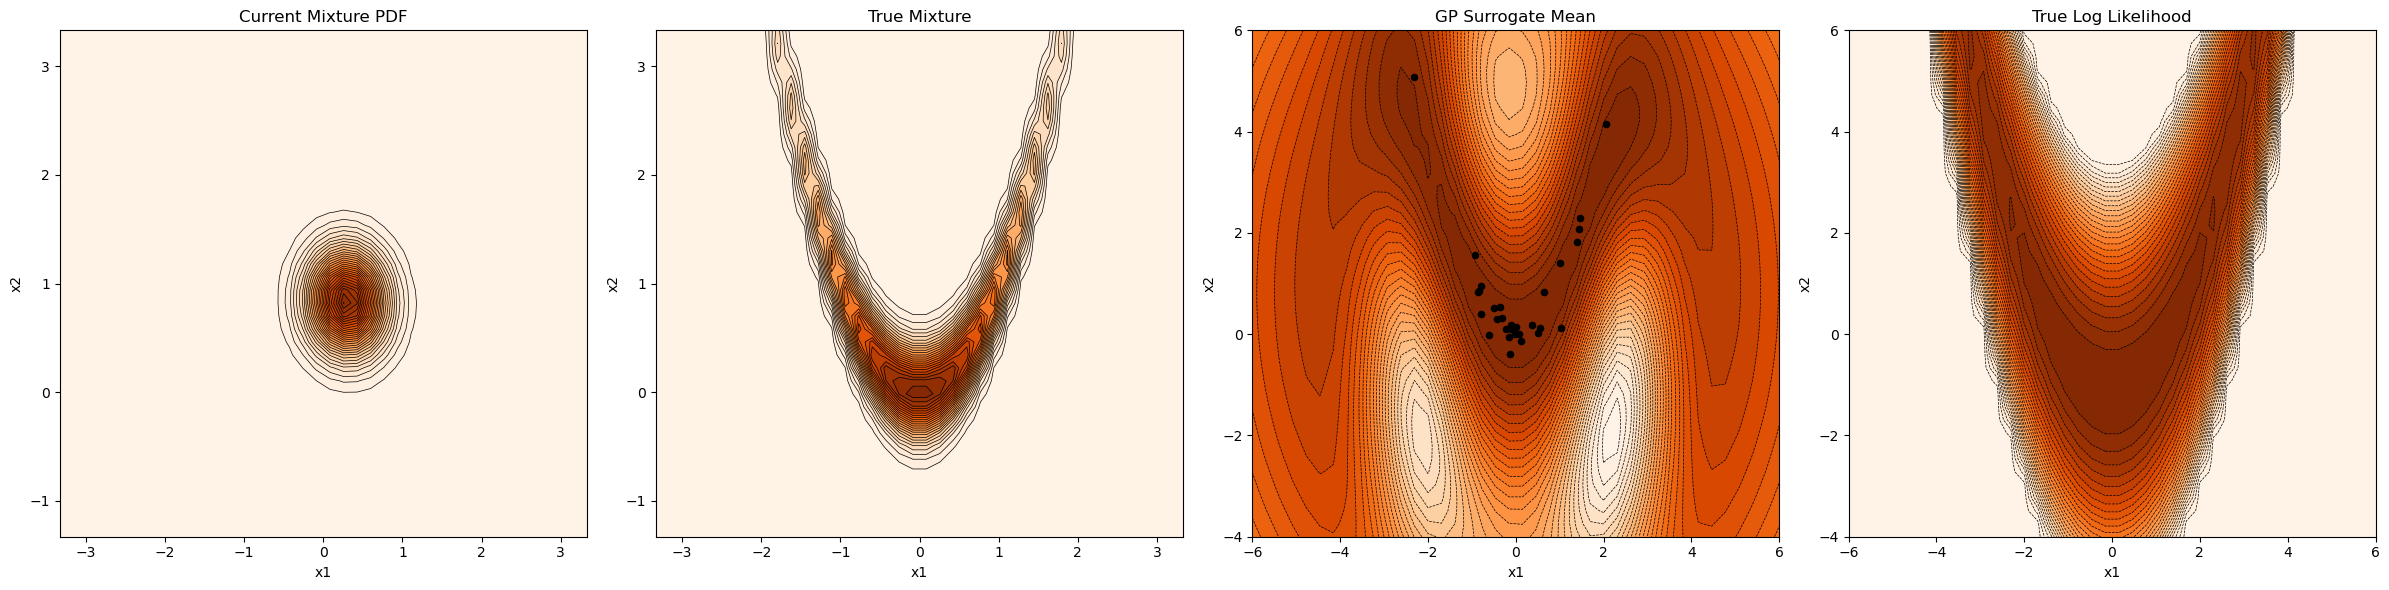

Beggining Iter 1
Iter 1, 1250: ELBO = -0.1707, ELCBO = -0.1708
Iter 1, 2500: ELBO = -0.1729, ELCBO = -0.1730
Iter 1, 3750: ELBO = -0.1730, ELCBO = -0.1732
Iter 1, 5000: ELBO = -0.1736, ELCBO = -0.1737
Iter 1, 6250: ELBO = -0.1745, ELCBO = -0.1747
Iter 1, 7500: ELBO = -0.1727, ELCBO = -0.1729
Iter 1, 8750: ELBO = -0.1703, ELCBO = -0.1705
Iter 1, 10000: ELBO = -0.1720, ELCBO = -0.1722
[0.5 0.5]
Adding new component.
doing active sampling before iter 2
finished active sampling before iter 2


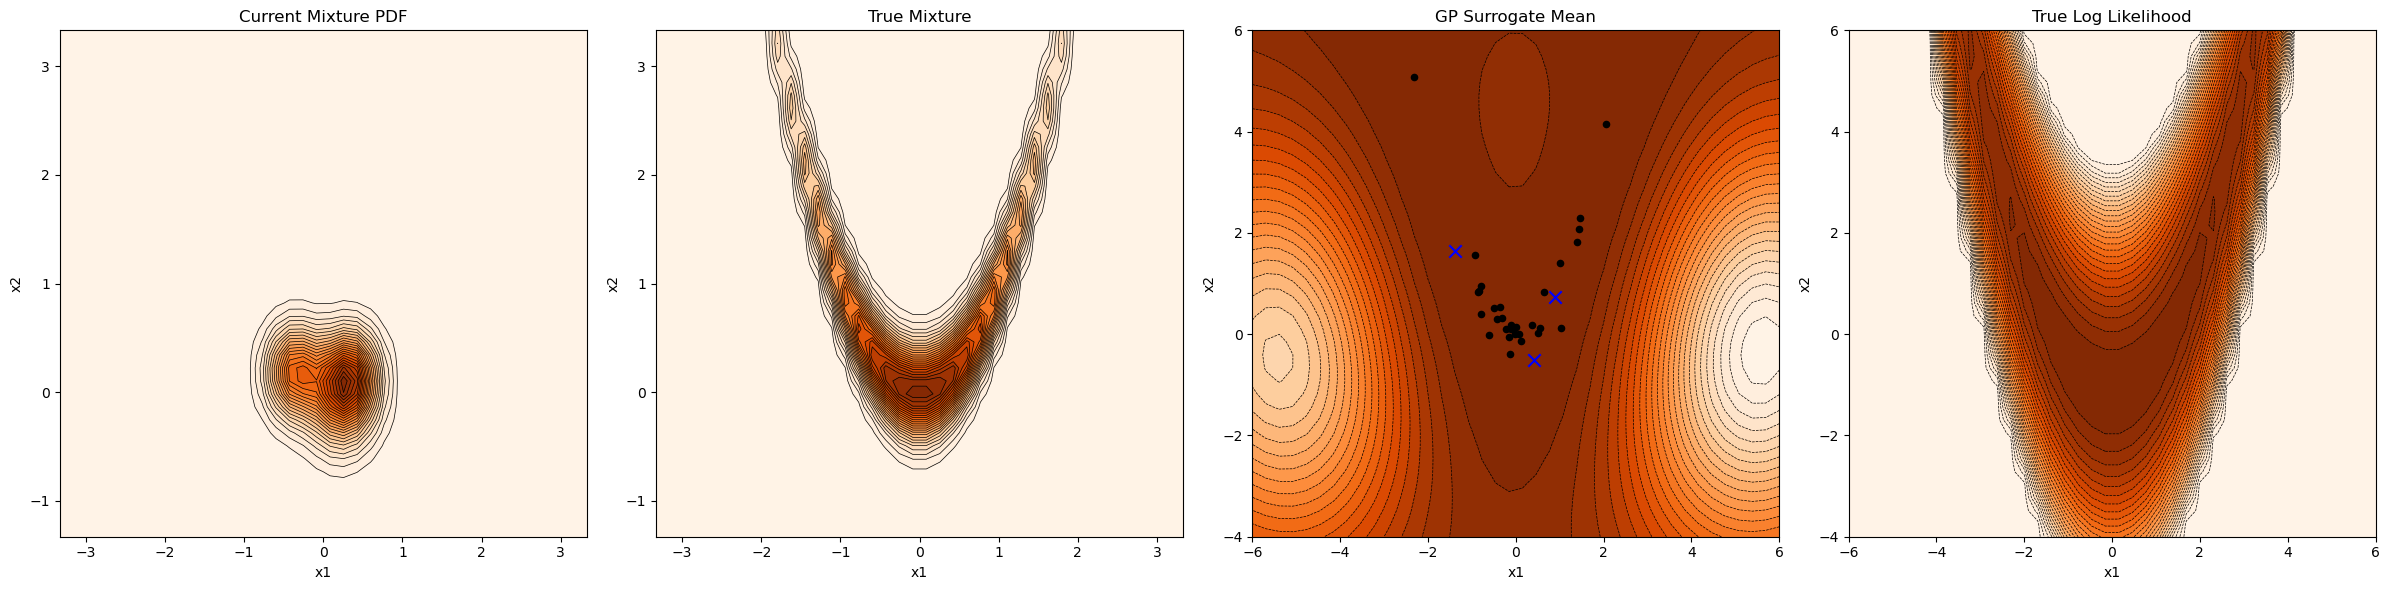

Beggining Iter 2
Iter 2, 1250: ELBO = -0.0100, ELCBO = -0.0100
Iter 2, 2500: ELBO = -0.0130, ELCBO = -0.0130
Iter 2, 3750: ELBO = -0.0117, ELCBO = -0.0117
Iter 2, 5000: ELBO = -0.0145, ELCBO = -0.0145
Iter 2, 6250: ELBO = -0.0138, ELCBO = -0.0138
Iter 2, 7500: ELBO = -0.0084, ELCBO = -0.0084
Iter 2, 8750: ELBO = -0.0112, ELCBO = -0.0112
Iter 2, 10000: ELBO = -0.0078, ELCBO = -0.0078
[0.33333333 0.33333333 0.33333333]
Adding new component.
doing active sampling before iter 3
finished active sampling before iter 3


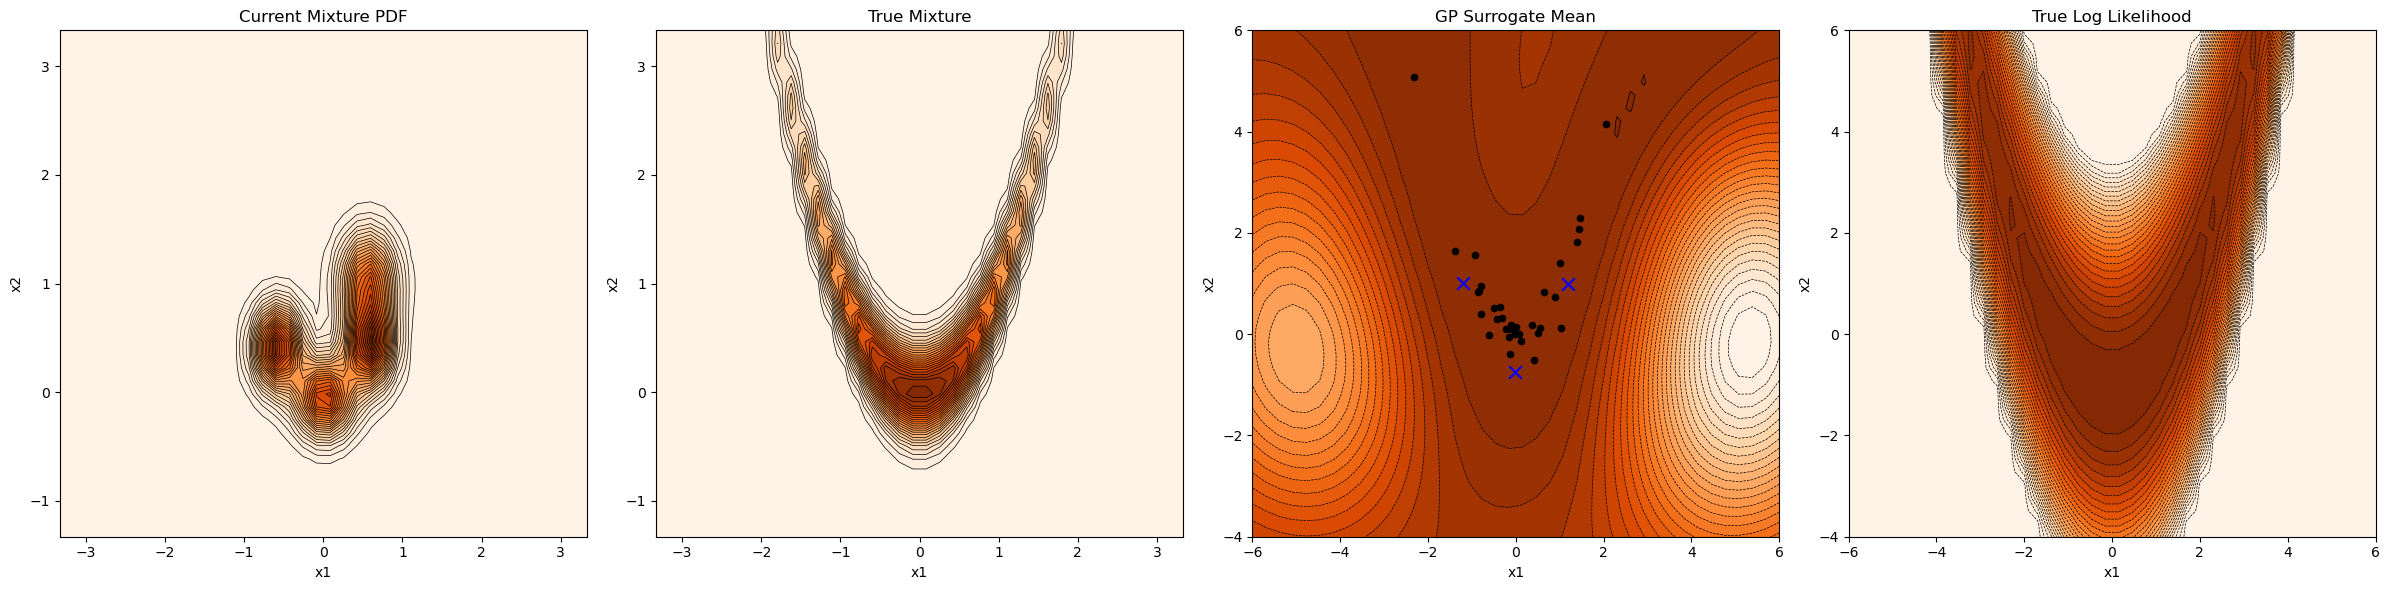

Beggining Iter 3
Iter 3, 1250: ELBO = 0.0709, ELCBO = 0.0709
Iter 3, 2500: ELBO = 0.0720, ELCBO = 0.0720
Iter 3, 3750: ELBO = 0.0738, ELCBO = 0.0738
Iter 3, 5000: ELBO = 0.0745, ELCBO = 0.0745
Iter 3, 6250: ELBO = 0.0711, ELCBO = 0.0711
Iter 3, 7500: ELBO = 0.0683, ELCBO = 0.0683
Iter 3, 8750: ELBO = 0.0751, ELCBO = 0.0751
Iter 3, 10000: ELBO = 0.0735, ELCBO = 0.0735
[0.25 0.25 0.25 0.25]
Adding new component.
doing active sampling before iter 4
finished active sampling before iter 4


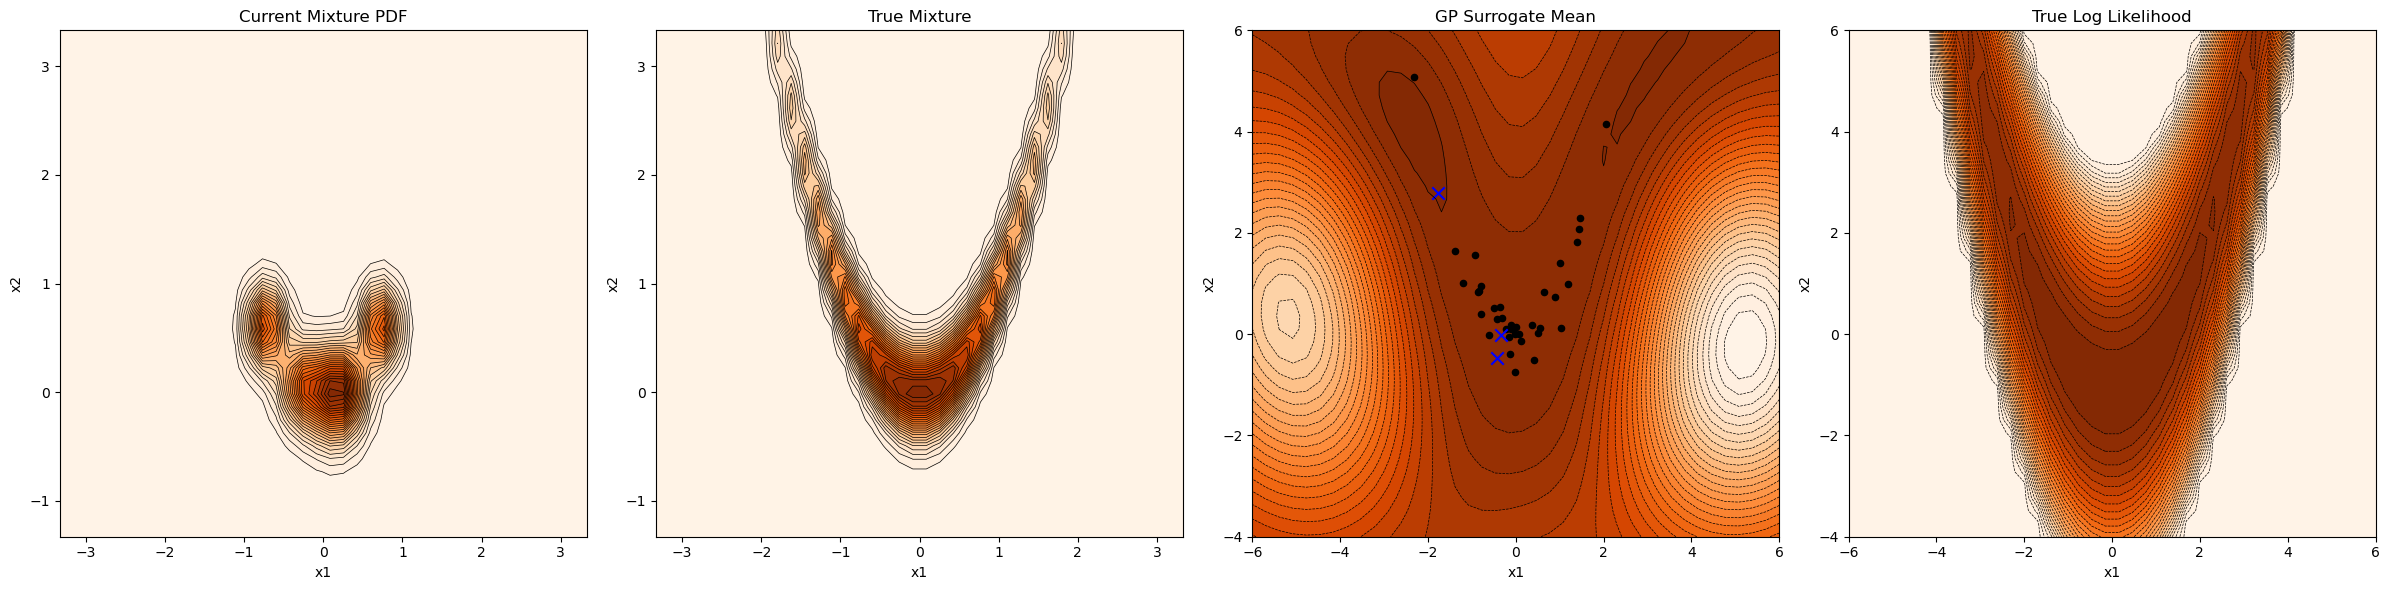

Beggining Iter 4
Iter 4, 1250: ELBO = 0.1425, ELCBO = 0.1425
Iter 4, 2500: ELBO = 0.1449, ELCBO = 0.1449
Iter 4, 3750: ELBO = 0.1428, ELCBO = 0.1428
Iter 4, 5000: ELBO = 0.1415, ELCBO = 0.1415
Iter 4, 6250: ELBO = 0.1429, ELCBO = 0.1429
Iter 4, 7500: ELBO = 0.1432, ELCBO = 0.1432
Iter 4, 8750: ELBO = 0.1426, ELCBO = 0.1426
Iter 4, 10000: ELBO = 0.1457, ELCBO = 0.1457
[0.2 0.2 0.2 0.2 0.2]
Adding new component.
doing active sampling before iter 5
finished active sampling before iter 5


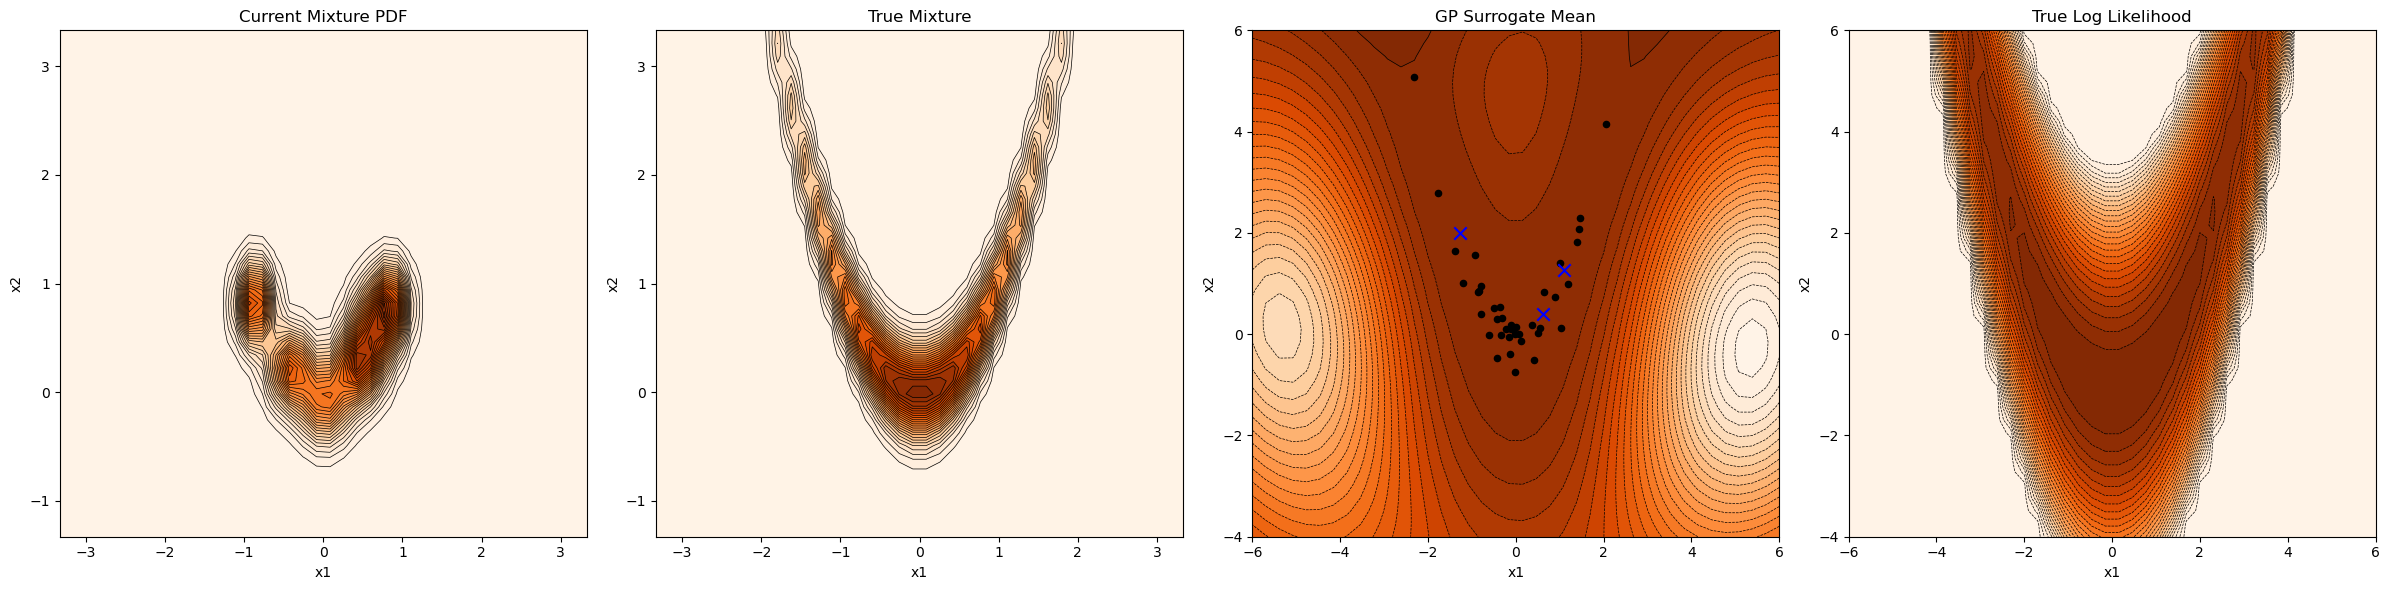

Beggining Iter 5
Iter 5, 1250: ELBO = 0.1885, ELCBO = 0.1885
Iter 5, 2500: ELBO = 0.1878, ELCBO = 0.1878
Iter 5, 3750: ELBO = 0.1904, ELCBO = 0.1904
Iter 5, 5000: ELBO = 0.1922, ELCBO = 0.1922
Iter 5, 6250: ELBO = 0.1898, ELCBO = 0.1898
Iter 5, 7500: ELBO = 0.1907, ELCBO = 0.1907
Iter 5, 8750: ELBO = 0.1897, ELCBO = 0.1897
Iter 5, 10000: ELBO = 0.1900, ELCBO = 0.1900
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]


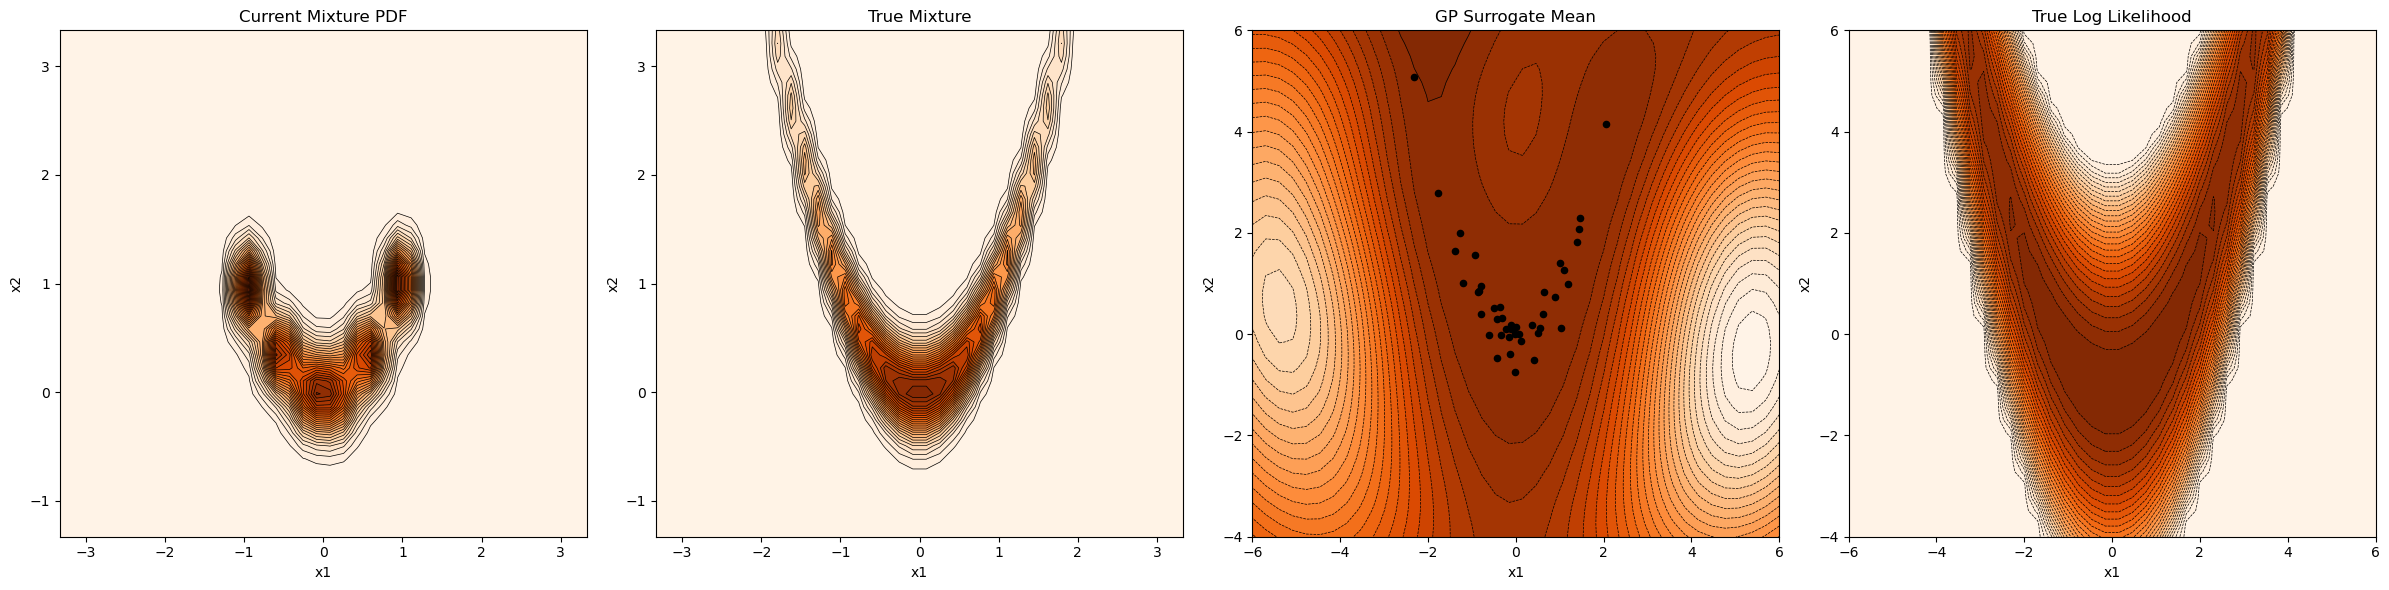

In [52]:
# Stack mu and log(s) for VBMC
grad_elbo = jit(grad(lambda *args, **kwargs: elbo(*args, **kwargs)[0]))

#Random key
seed = int(time.time()*1e6)
key = jax.random.PRNGKey(seed)

L = jnp.array([8,7])
params, best_elbo, elbo_history, best_elcbo, elcbo_history = vbmc(
    x_obs, y_obs, grad_elbo, s=s, L=L, 
    alpha=1.2, beta=0.2, gamma=1.2,
    lr=0.05, k=2, n_points=3,
    rsp=5, n1=5, n2=10_000, 
    plots=True, ll=expensive_log_likelihood, 
    params_true=params_true,
    weights=True,
    key=key)


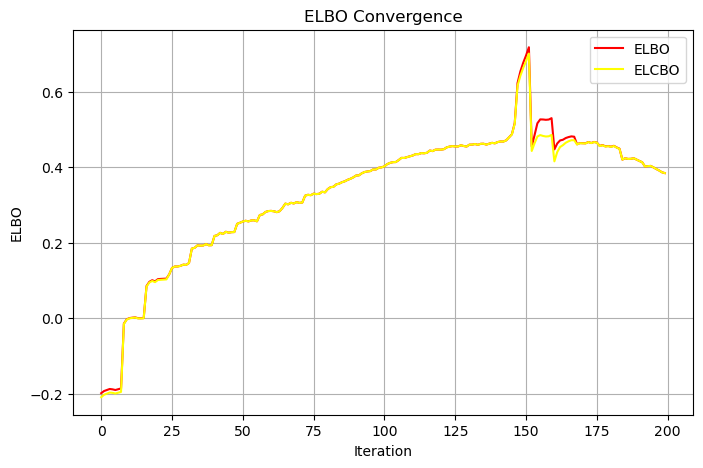

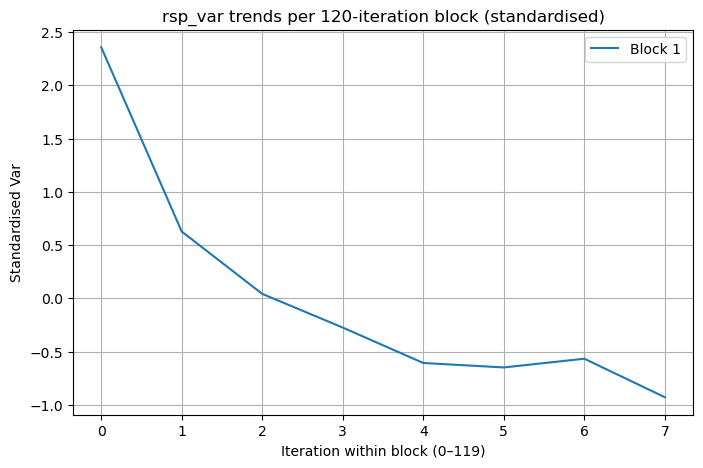

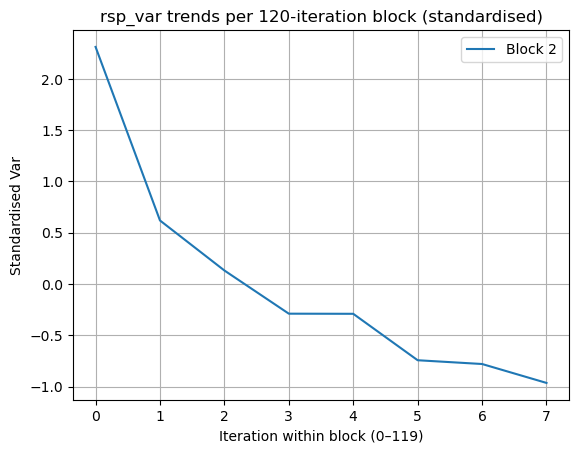

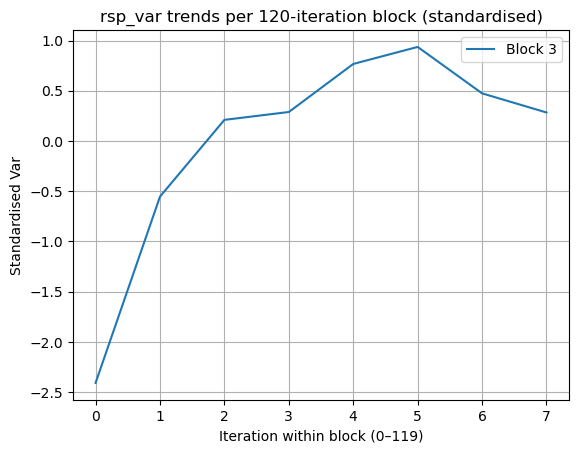

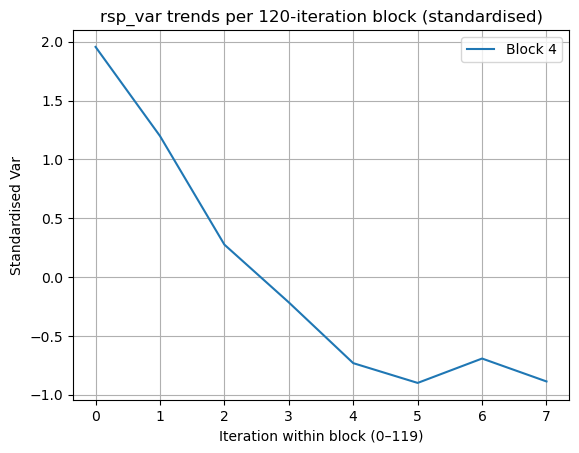

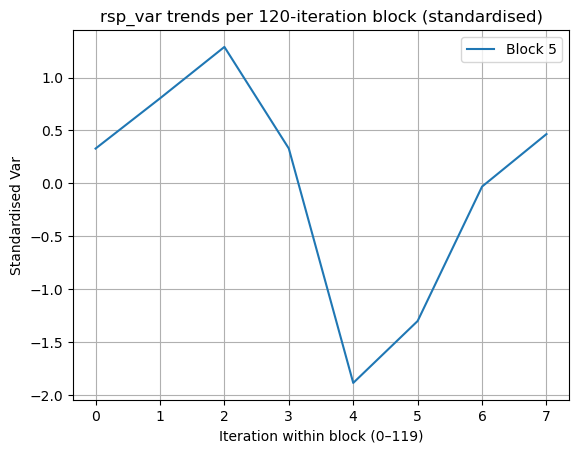

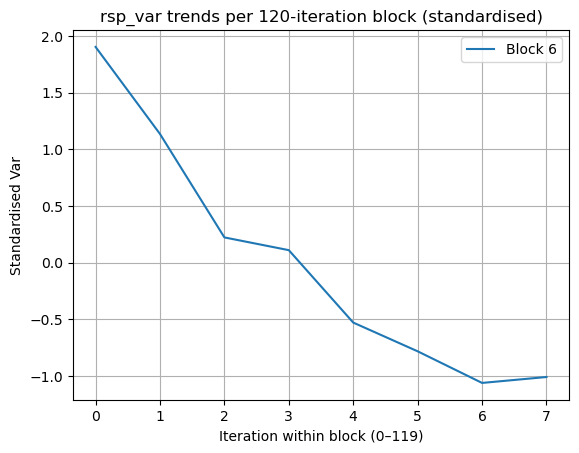

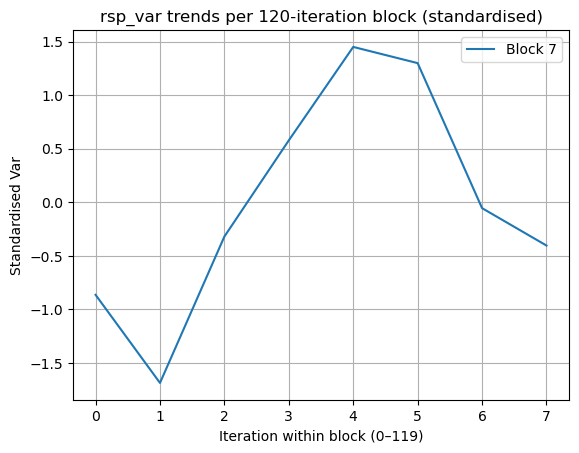

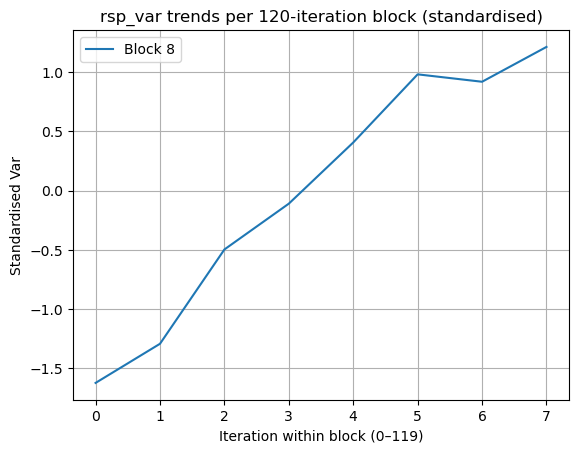

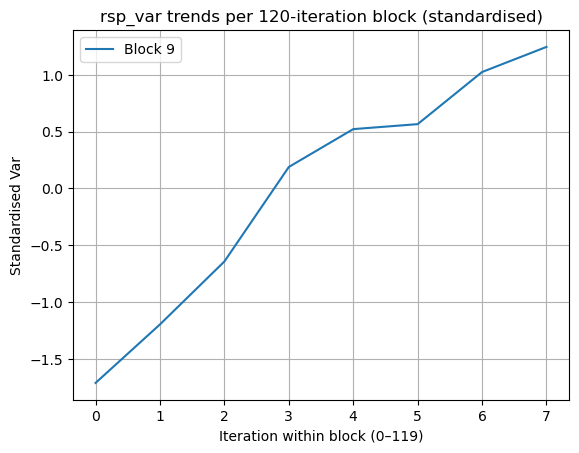

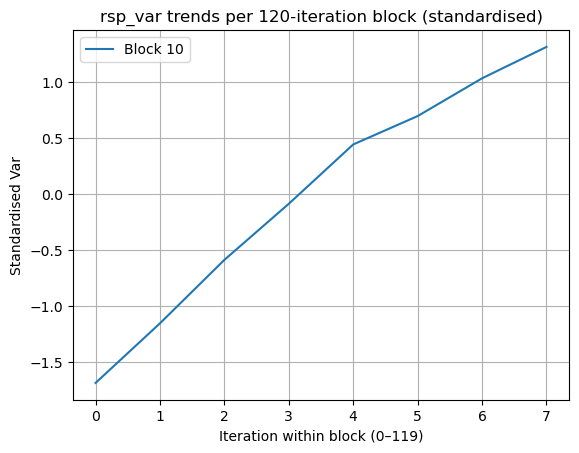

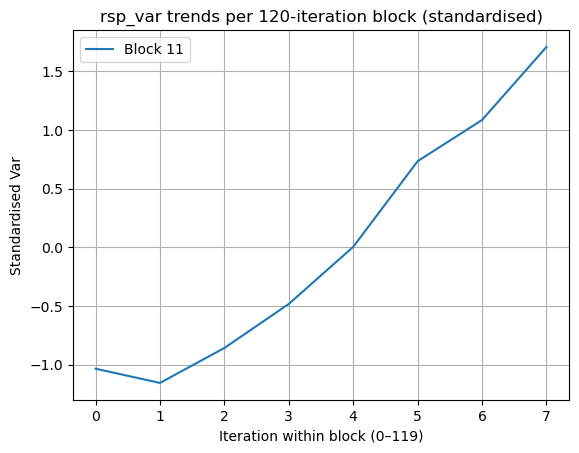

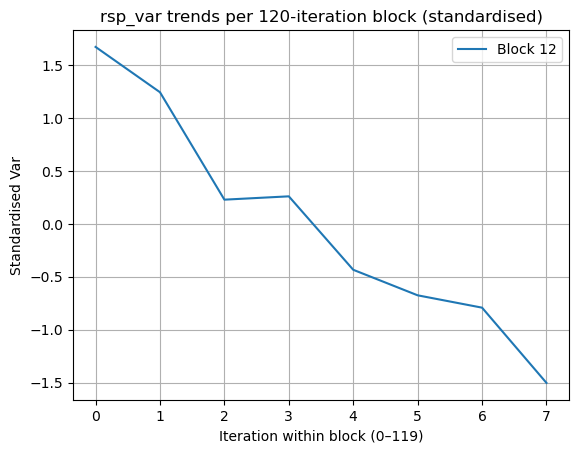

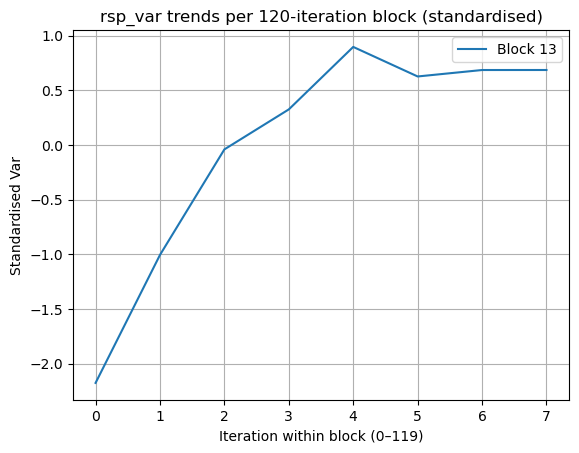

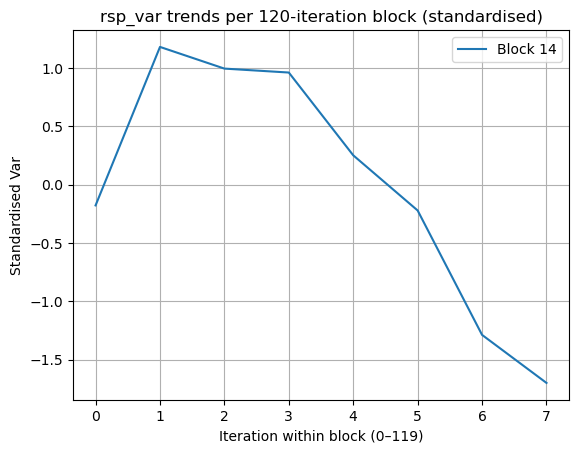

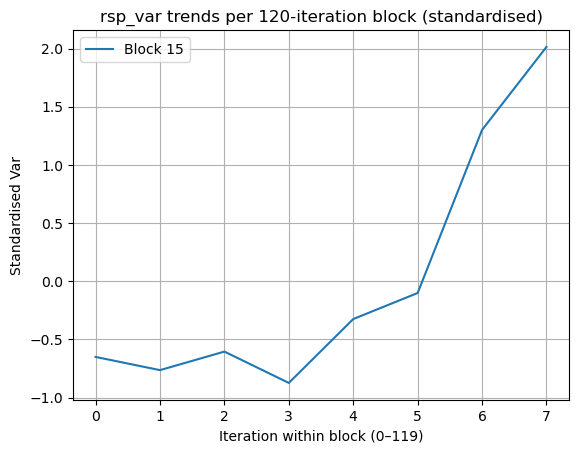

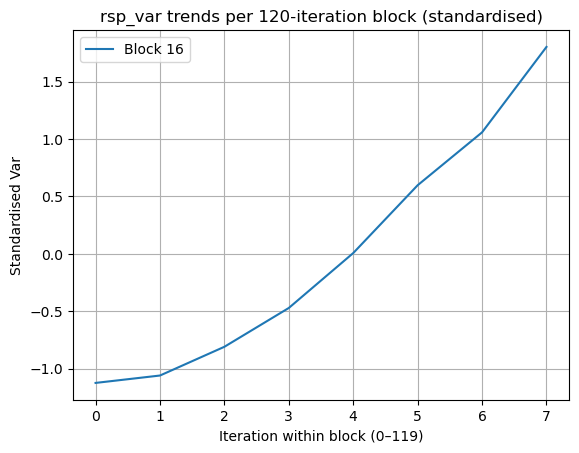

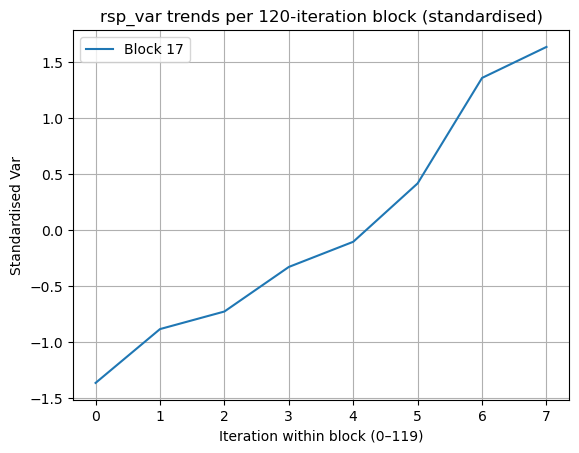

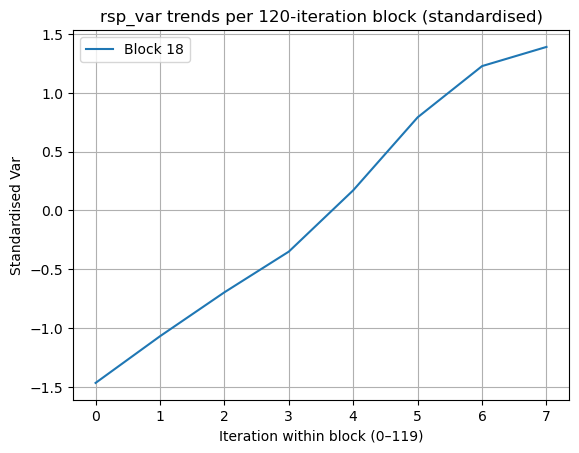

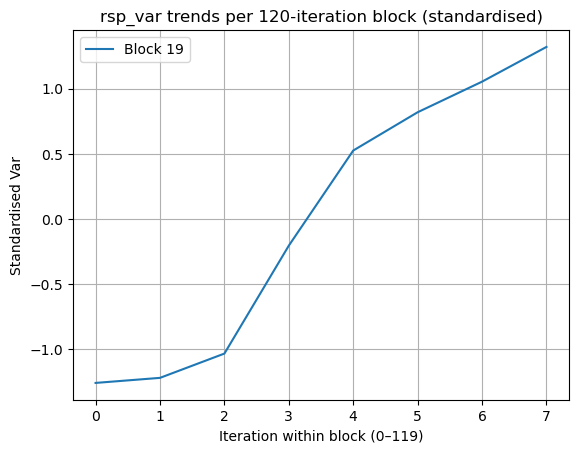

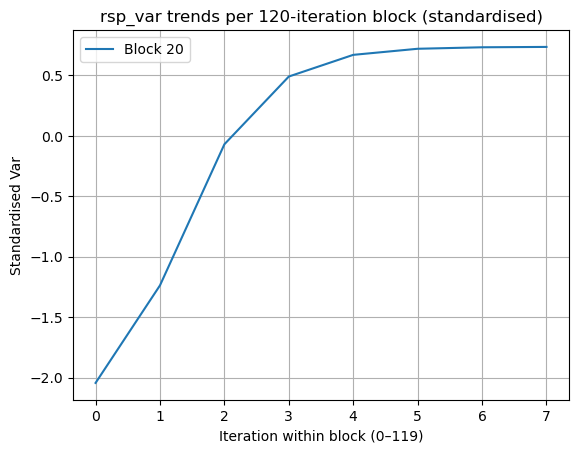

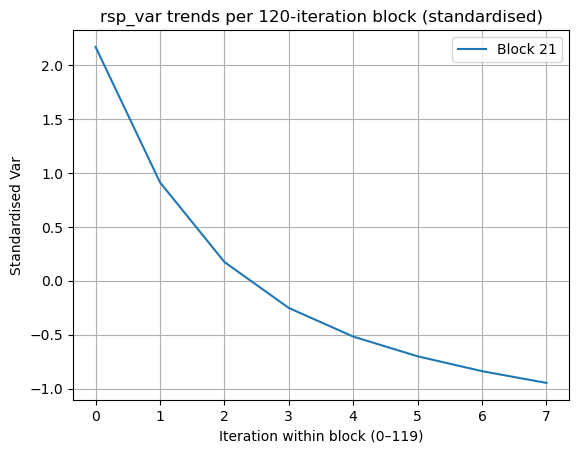

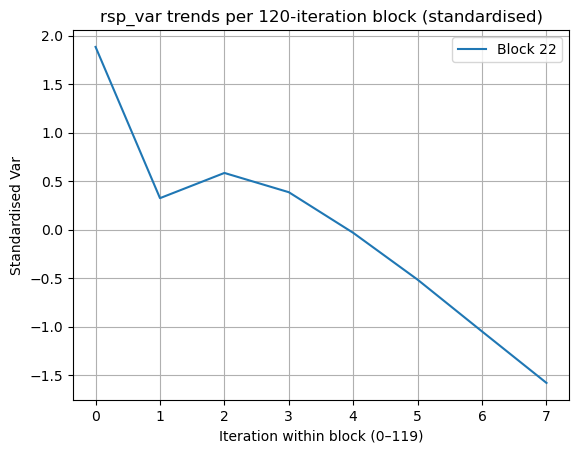

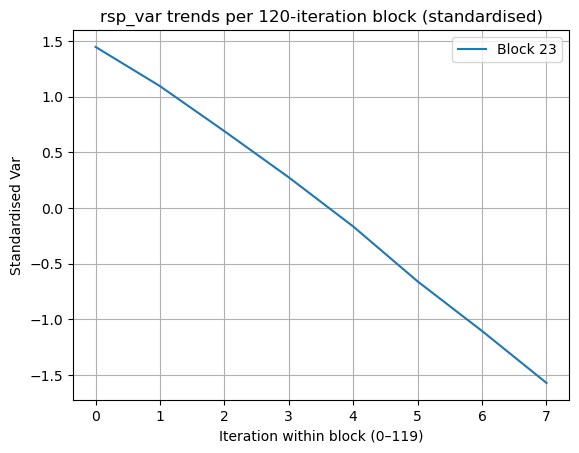

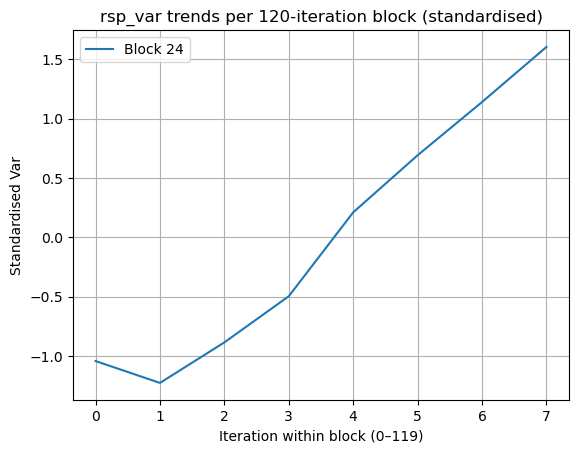

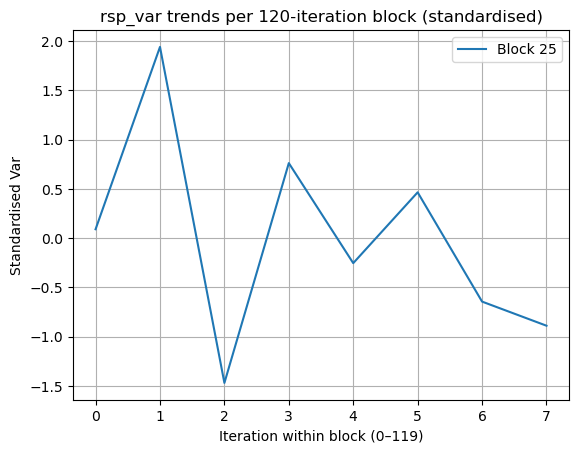

In [14]:
# Plot ELBO history
plt.figure(figsize=(8,5))
plt.plot(elbo_history, label='ELBO', color='red')
plt.plot(elcbo_history, label='ELCBO', color='yellow')
plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.title("ELBO Convergence")
plt.legend()
plt.show()



rsp_var = np.array(elbo_history)-np.array(elcbo_history)

block_size = 8
n_blocks = len(rsp_var) // block_size

plt.figure(figsize=(8,5))
for i in range(n_blocks):
    start = i * block_size
    end = start + block_size
    block = rsp_var[start:end]
    block = (block - np.mean(block)) / np.std(block)
    plt.plot(range(block_size), block, label=f'Block {i+1}')
    plt.grid(True)
    plt.xlabel("Iteration within block (0–119)")
    plt.ylabel("Standardised Var")
    plt.title("rsp_var trends per 120-iteration block (standardised)")
    plt.legend()
    plt.show()